## 1. Import Required Libraries


In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
torch.__version__


'2.8.0'

In [3]:
torchvision.__version__

'0.23.0'

## 2. Setup Device Agnostic Code


In [12]:
torch.cuda.is_available()

False

In [15]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [16]:
print(f"Using Device:{device}")

Using Device:mps


## 3. Set the seed

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the Hyperparameters

In [19]:
1e-3

0.001

In [67]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.0003
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.2

## 5. Define Image Transformations

In [68]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5))
#     # Helps the model to converge faster
#     # Helps to make the numerical computations stable
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

## 6. Getting Dataset

In [69]:
train_dataset = datasets.CIFAR10(root = "data",
                                 train = True,
                                 download = True,
                                 transform = transform_train
                                 )

In [70]:
test_dataset = datasets.CIFAR10(root = "data",
                                 train = False,
                                 download = True,
                                 transform = transform_test
                                 )

In [71]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [72]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [73]:
len(train_dataset)

50000

In [74]:
len(test_dataset)

10000

## 7. Converting our Datasets into DataLoaders
Right now, our data is in the form of Pytorch Datasets,

Dataloaders turns our data into batches (or mini-batches)

Why?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 50k images in one hit. So we can break it into 128 images at a time.(batch size of 128).

2. It gives our neural network more chances to update its gradient per epoch

In [75]:
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True
                          )

test_loader= DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False
                          )

In [76]:
print(f"Dataloader: {train_loader, test_loader}")
print(f"Length of trainloader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of testloader: {len(test_loader)} batches of {BATCH_SIZE}...")

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x370d4aad0>, <torch.utils.data.dataloader.DataLoader object at 0x17cd39480>)
Length of trainloader: 391 batches of 128...
Length of testloader: 79 batches of 128...


## 8. Building Vision Transformer Model from Scratch

In [77]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim
               ):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels = in_channels,
                          out_channels = embed_dim,
                          kernel_size=patch_size,
                          stride = patch_size
                          )
    num_patches = (img_size //patch_size)**2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 +num_patches, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) #(B, E, H/P, W/P)
    x = x.flatten(2).transpose(1,2) #(B,N,E)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim = 1)
    x = x + self.pos_embed
    return x

In [78]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
    self.fc2 = nn.Linear(in_features = hidden_features, out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x



In [79]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout = drop_rate, batch_first = True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self,x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x+ self.mlp(self.norm2(x))
    return x

In [80]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = (PatchEmbedding(img_size, patch_size, in_channels, embed_dim))
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [81]:
#Instantiate Model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [82]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## 9. Defining a Loss function and Optimizer


In [83]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LEARNING_RATE) # update our models parameters to try and reduce the loss

In [84]:
criterion

CrossEntropyLoss()

In [85]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## 10. Defining a training loop Function

In [86]:
def train(model, loader, optimizer, criterion):
  #Set the mode of the model into training
  model.train()

  total_loss, correct = 0,0

  for x, y in loader:
    #Sending data into target device
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    #1.Forward pass ( model output raw logits)
    out = model(x)
    #2. Calculate loss (per batch)
    loss = criterion(out, y)
    #3. Perform back propagation
    loss.backward()
    #4. Perform Gradient Descent
    optimizer.step()

    total_loss += loss.item()*x.size(0)
    correct += (out.argmax(1) == y).sum().item()
  # You have to scale the loss (Normalization step to make the loss general across all batches by dividing  the loss,len dataloader)
  return total_loss/len(loader.dataset), correct/len(loader.dataset)

In [87]:
def evaluate (model, loader):
  model.eval() # set the mode of the model into evaluation
  correct = 0
  with torch.inference_mode():
    for x,y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct +=(out.argmax(dim = 1)==y).sum().item()
  return correct/len(loader.dataset)


In [88]:
EPOCHS

20

In [89]:
from tqdm.auto import tqdm

In [90]:
# Training
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss:{train_loss:.4f}, Train acc:{train_acc:.4f}%, Test acc: {test_acc:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train loss:1.8910, Train acc:0.3004%, Test acc: 0.4277
Epoch: 2/20, Train loss:1.5988, Train acc:0.4191%, Test acc: 0.4940
Epoch: 3/20, Train loss:1.4641, Train acc:0.4690%, Test acc: 0.5237
Epoch: 4/20, Train loss:1.3686, Train acc:0.5050%, Test acc: 0.5487
Epoch: 5/20, Train loss:1.2974, Train acc:0.5338%, Test acc: 0.5736
Epoch: 6/20, Train loss:1.2488, Train acc:0.5514%, Test acc: 0.5785
Epoch: 7/20, Train loss:1.2039, Train acc:0.5675%, Test acc: 0.5924
Epoch: 8/20, Train loss:1.1621, Train acc:0.5848%, Test acc: 0.5992
Epoch: 9/20, Train loss:1.1243, Train acc:0.5957%, Test acc: 0.6089
Epoch: 10/20, Train loss:1.0825, Train acc:0.6130%, Test acc: 0.6352
Epoch: 11/20, Train loss:1.0523, Train acc:0.6233%, Test acc: 0.6341
Epoch: 12/20, Train loss:1.0214, Train acc:0.6359%, Test acc: 0.6386
Epoch: 13/20, Train loss:0.9919, Train acc:0.6455%, Test acc: 0.6500
Epoch: 14/20, Train loss:0.9712, Train acc:0.6531%, Test acc: 0.6510
Epoch: 15/20, Train loss:0.9403, Train acc:

In [91]:
train_accuracies

[0.30044,
 0.41908,
 0.469,
 0.50496,
 0.5338,
 0.5514,
 0.56748,
 0.58482,
 0.59566,
 0.613,
 0.62332,
 0.6359,
 0.64552,
 0.65314,
 0.666,
 0.67386,
 0.68232,
 0.6898,
 0.6992,
 0.70654]

In [63]:
import random

In [64]:
def predict_and_plot_grid(model, dataset, classes, grid_size = 3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize = (9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) -1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim = 0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data,1)
      img = img/2 +0.5 #Unnormalize our images to use with matplotlib
      npimg = img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg,(1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"
      axes[i,j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]} ", fontsize = 10, c= color)
      axes[i,j].axis("off")
  plt.tight_layout()
  plt.show()


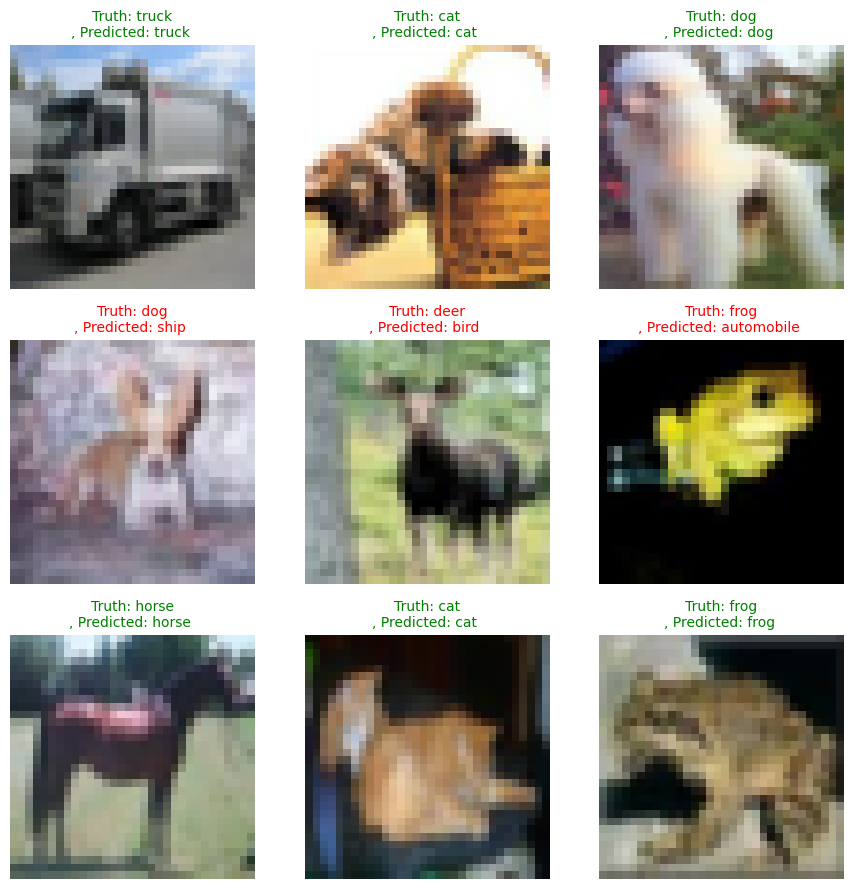

In [66]:
predict_and_plot_grid(model, test_dataset, classes = train_dataset.classes, grid_size = 3)